# Part 1: Methods for Asian Options

In this Jupyter notebook we consider an Asian option with the following payoff:

$\max( \frac{1}{N}\sum \limits _{n=1} ^{N} S_n - K, 0)$

where $S_n$ are daily closing prices of the underlying and $K$ is the fixed strike price. This option in particular is referred to as a Fixed Strike Asian Call Option with Discrete Arithmetic Average.

An Asian option is an option contract where the payoff is based on the average price of the underlying asset over a predetermined period of time. This type of option is useful for investors looking to hedge their positions against changes in the underlying asset price over a long period of time. Asian options are typically used for hedging against currency fluctuations or interest rate changes.

To describe the underlying process, we use the geometric Brownian motion:

$dS_t = rS_tdt + \sigma(S_t,t)S_tdW_t$

where the local volatility, $\sigma$ is given by $\sigma(S,t) = \sigma_0(1+\sigma_1\cos(2\pi t))(1+\sigma_2\exp(-S/50))$

where $\sigma_0 = 0.2$, $\sigma_1 = 0.3$ ,and $\sigma_2 = 0.5$ with the time $t$ being given in years.

This Brownian motion allows for the possibility that the volatility can depend on the current time $t$ and current value of underlying asset $S_t$

Unless otherwise specified we will use the following parameters:

- The strike price $K$ is 110
- The interest rate $r$ is 0.05
- There are 260 working days in a year
- The number of sample paths $N_{paths}$ is 1000

We investigate how to price Asian option by Monte-Carlo simulations by employing different variance reduction techniques. These include:

- A function without variance reduction (naive method)
- A function utilizing the antithetic variance reduction
- Several functions using different control variates

In [1]:
# Import libraries necessary for plotting graphs and performing calculations
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean
import tabulate
import time

In [2]:
# construct random generator 
rng = np.random.default_rng(12345)

In [3]:
# Program the local volatility equation

def volatility(S,t,sigma_0):
    
    # function to compute and return the local volatility
    
    sigma = sigma_0*(1+0.3*np.cos(2*np.pi*t))*(1+0.5*np.exp(-S/50))

    return sigma

# Naive method to price an Asian option

It is naive to price an Asian option without variance reduction techniques because this method does not take into account the potential volatility of the underlying asset. This means that the option value will not be accurate and could result in a loss for the investor. Additionally, this method does not consider the time value of money, which means that the option value will not reflect the changing market conditions.

In [4]:
# Program the timestepping function for the Naive method to price an Asian option

def SDE_timestepper(S0, T, r, sigma_0, Npaths):
    
    # Simulate GBM paths
    # returns the time array and the paths
    
    # Use a time step of 1 day assuming 260 days/year
    Nsteps = int(260 * T)
    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S = np.zeros((Nsteps+1, Npaths))
    
    # Time step starting from initial condition
    S[0,:] = S0  
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
        S[n+1,:] = S[n,:] * (1. + r*dt + volatility(S[n,:],t[n],sigma_0) * dW[:])

    return t, S

In [5]:
def SDE_asian_call_vol(S0, K, T, r, sigma_0, Npaths):
    
    # Record time
    
    start_time = time.time()
    
    # price Asian call option by simulating GBM paths
    # returns the price and variance
    
    t, S = SDE_timestepper(S0, T, r, sigma_0, Npaths)
    
    # discounted payoff for Asian call
    fS = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)

    price = np.mean(fS)
    variance = np.var(fS)
    
    # Compute time taken of function
    
    Naive_time = time.time() - start_time
    
    return price, variance, Naive_time

# Antithetic variance reduction method to price an Asian option

This method involves taking the average of two opposite positions in the underlying asset and using that average to calculate the option value. This method reduces the variance of the option value by taking into account the potential volatility of the underlying asset.

In [6]:
def SDE_timestepper_ant(S0, T, r, sigma_0, Npaths):
    
    # simulate GBM paths
    # with antithetic variance reduction
    # returns time array and paths
    
    # Use a time step of 1 day assuming 260 days/year
    Nsteps = int(260 * T)
    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    Sp = np.zeros((Nsteps+1, Npaths))
    Sm = np.zeros((Nsteps+1, Npaths))
    
    # Time step starting from initial condition
    Sp[0,:] = S0 
    Sm[0,:] = S0 
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
        Sp[n+1,:] = Sp[n,:] * (1. + r*dt + volatility(Sp[n,:],t[n],sigma_0) * dW[:])
        Sm[n+1,:] = Sm[n,:] * (1. + r*dt - volatility(Sm[n,:],t[n],sigma_0) * dW[:])

    return t, Sp, Sm

In [7]:
def SDE_asian_call_volant(S0, K, T, r, sigma_0, Npaths):
    
    # Record time
    
    start_time = time.time()
        
    t, Sp, Sm = SDE_timestepper_ant(S0, T, r, sigma_0, Npaths)
    
    # discounted payoffs based on Sp, Sm at final time
    fSp = np.exp(-r*T)*np.maximum(np.mean(Sp,axis=0)-K,0)
    fSm = np.exp(-r*T)*np.maximum(np.mean(Sm,axis=0)-K,0)
    
    # compute and return price and variance
    Z = (fSp + fSm)/2
    price = np.mean(Z)
    variance = np.var(Z)
    
    # Compute time taken of function
    
    Ant_time = time.time() - start_time
    
    return price, variance, Ant_time

# Pricing an Asian option using control variates

This method involves taking a linear combination of two or more random variables, such as the underlying asset price and a benchmark option, and then using that linear combination to calculate the option value. The expected value of the option is estimated by using a control variate, such as a European option with the same underlying assets and time to maturity. 

We begin by defining our timestepping function to generate both $Z_t$ and $S_t$; where $Z_t$ is governed by geometric Brownian motion:

$dZ_t = rZ_tdt + \bar{\sigma}Z_tdW_t$

where $r$ and $\bar{\sigma}$ are constant. In particular, we denote the constant-volatitility $\bar{\sigma}$ by $\sigma(S_0,0)$ as it is the very first value the local-volatility takes at time $t = 0$.

In [8]:
def SDE_control_timestepper(S0, T, r, sigma_0, Npaths):
    
    # Simulate GBM paths
    # returns the time array and the paths
    
    # Use a time step of 1 day assuming 260 days/year
    Nsteps = int(260 * T)
    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S = np.zeros((Nsteps+1, Npaths))
    Z = np.zeros((Nsteps+1, Npaths))
    
    # Time step starting from initial condition
    S[0,:] = S0  
    Z[0,:] = S0
    for n in range(Nsteps):
        dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
        S[n+1,:] = S[n,:] * (1. + r*dt + volatility(S[n,:], t[n], sigma_0) * dW[:])
        Z[n+1,:] = Z[n,:] * (1. + r*dt + volatility(S[0,:], 0, sigma_0) * dW[:])

    return t, S, Z

We program the function using the first control variate of just $Z_T$ at the final time. This has a known expectation.

In [9]:
def SDE_control_variate_1(S0, K, T, r, sigma_0, Npaths):
    
    # Record time
    
    start_time = time.time()
    
    t, S, Z = SDE_control_timestepper(S0, T, r, sigma_0, Npaths)
    
    # Compute mean and variance using equations from lecture slides

    mean_ST = S[0,:]*np.exp(r*T)
    var_ST = (mean_ST**2)*(np.exp((volatility(S[0,:],0,sigma_0)**2*T))-1)
    
    # Discounted payoff for Asian call
    
    fST = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)
    
    # Calculate covariance and hence the constant c 
    
    cov_fST_ST = np.mean(fST*Z[-1,:]) - np.mean(fST)*np.mean(Z[-1,:])
    c = cov_fST_ST/var_ST
    
    # Compute f_c
    
    f_c = fST-c*(Z[-1,:]-mean_ST)
    
    # Compute and return the price and variance
    
    price = np.mean(f_c)
    variance = np.var(f_c)
    
    # Compute time taken of function
    
    cv1_time = time.time() - start_time
    
    return price, variance, cv1_time

We program the function using the second control variate $e^{-rT}\max(Z_T-K,0)$ which happens to be the discounted payoff for a  European call option, and hence the expectation is given by the Black-Scholes formula.

In [10]:
# Define Black-Scholes call function to give the expectation of the discoutned payoff for a European call option

def BS_call(S0, K, T, r, sigma_0):
    
    t, S, Z = SDE_control_timestepper(S0, T, r, sigma_0, Npaths)
    
    d1 = (np.log(S[0,:]/K) + (r + volatility(S[0,:], 0, sigma_0)**2 /2) * T)/(volatility(S[0,:], 0, sigma_0)*np.sqrt(T))
    d2 = d1 - volatility(S[0,:], 0, sigma_0) * np.sqrt(T)
    return S[0,:] * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)


In [11]:
def SDE_control_variate_2(S0, K, T, r, sigma_0, Npaths):
    
    # Record time
    
    start_time = time.time()
    
    t, S, Z = SDE_control_timestepper(S0, T, r, sigma_0, Npaths)
    
    # Compute expectation of discounted payoff for a European call option using the Black-Scholes formula
    
    mean_ST = BS_call(S0, K, T, r, sigma_0)
    
    # Discounted payoff for Asian call and control variate
    
    fST = np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)
    fZT = np.exp(-r*T)*np.maximum(Z[-1,:] - K, 0)
    
    # Compute covariance
    
    var_ST = np.var(fZT)
    cov_fST_fZT = np.mean(fST*fZT) - np.mean(fST)*np.mean(fZT)
    
    # Put in if loop to avoid instances of 0 variance which cause a division error in the computation of the constant c
    
    if var_ST == 0:
        c = 0
    else:
        c = cov_fST_fZT/var_ST
    
    # Compute f_c
    
    f_c = fST-c*(fZT - mean_ST)
    
    # Compute and return price and variance
    
    price = np.mean(f_c)
    variance = np.var(f_c)
    
    # Compute time taken of function
    
    cv2_time = time.time() - start_time
    
    return price, variance, cv2_time

We program the function using the third control variate $\max((\prod_{n=0}^{N}Z_n)^{\frac{1}{N+1}}-K,0)$ which is the discounted payoff for a geometrically averaged Asian option, for which there is also a formula for the expectation:

$Z_0\exp((r_g-r)T)N(d_1)-K\exp(-rT)N(d_2)$

where $N()$ is the cumulative distribution function of the standard normal distribution and the other variables are defined in the code below:

In [12]:
def SDE_control_variate_3(S0, K, T, r, sigma_0, Npaths):
    
    # Record time
    
    start_time =  time.time()
    
    t, S, Z = SDE_control_timestepper(S0, T, r, sigma_0, Npaths)
    
    Nsteps = int(260 * T)
    
    #define variables to compute expectation of the discounted payoff for a geometrically averaged Asian option
    
    vol_g = volatility(S[0,:], 0, sigma_0)*np.sqrt((2*Nsteps+1)/(6*(Nsteps+1)))
    r_g = 0.5*(r-0.5*vol_g**2)
    d1 = (np.log(S0/K)+(r_g+0.5*vol_g**2)*T)/(vol_g*np.sqrt(T))
    d2 = d1 - vol_g*np.sqrt(T)
    mean_fZT = S0*np.exp((r_g-r)*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    # Discounted payoff for Asian call and control variate as well as computation of the variance
    
    fZT = np.exp(-r*T)*np.maximum(gmean(Z, axis=0) - K, 0)
    var_fZT = np.var(fZT)
    fS = np.exp(-r*T)*np.maximum(np.mean(S, axis=0) - K, 0)
    
    # Compute covariance and add an if loop to avoid division error to successfully compute the constant c
    
    cov_fST_ZT = np.mean(fS*fZT) - np.mean(fS)*np.mean(fZT)
    
    if var_fZT == 0:
        c = 0
    else:
        c = cov_fST_ZT/var_fZT
    f_c = fS-c*(fZT-mean_fZT)
    
    # Compute and return the price and variance
    
    price = np.mean(f_c)
    variance = np.var(f_c)
    
    # Compute time taken of function
    
    cv3_time = time.time() - start_time
    
    return price, variance, cv3_time

# Analysis of results

Here we price the options at different intial values of spot price $S_0 = S(t=0)$ with the time fixed to maturity and obtain 95% confidence intervals for each case.

In [13]:
# Set parameters

K= 110
T=3
r=0.05
sigma_0=0.2
Npaths=1000

In [14]:
# Compute prices, variances, and confidence intervals using initial spot price S = 85

SDE_price_1, SDE_var_1, _ = SDE_asian_call_vol(85, K, T, r, sigma_0, Npaths)
SEM_1 = np.sqrt(SDE_var_1/Npaths)
print("Naive price = ", round(SDE_price_1,4), "+/-", format(1.96*SEM_1,'.2g'))

SDE_price_ant_1, SDE_var_ant_1, _ = SDE_asian_call_volant(85,K,T,r,sigma_0,Npaths)
SEM_ant_1 = np.sqrt(SDE_var_ant_1/Npaths)
print("Antithetic MC price is ", '{0:.5g}'.format(SDE_price_ant_1), "+/-", '{0:.2g}'.format(1.96*SEM_ant_1) )

SDE_control_1_price_1, SDE_control_1_var_1, _ = SDE_control_variate_1(85, K, T, r, sigma_0, Npaths)
SEM_cv1_1 = np.sqrt(SDE_control_1_var_1/Npaths)
print("Control Variate 1 price = ", round(SDE_control_1_price_1,4), "+/-", format(1.96*SEM_cv1_1,'.2g'))

SDE_control_2_price_1, SDE_control_2_var_1, _ = SDE_control_variate_2(85, K, T, r, sigma_0, Npaths)
SEM_cv2_1 = np.sqrt(SDE_control_2_var_1/Npaths)
print("control variate 2 price = ", round(SDE_control_2_price_1,4), "+/-", format(1.96*SEM_cv2_1,'.2g'))

SDE_control_3_price_1, SDE_control_3_var_1, _ = SDE_control_variate_3(85, K, T, r, sigma_0, Npaths)
SEM_cv3_1 = np.sqrt(SDE_control_3_var_1/Npaths)
print("control variate 3 price = ", round(SDE_control_3_price_1,4), "+/-", format(1.96*SEM_cv3_1,'.2g'))

Naive price =  2.6184 +/- 0.46
Antithetic MC price is  2.0631 +/- 0.28
Control Variate 1 price =  2.3947 +/- 0.32
control variate 2 price =  2.4377 +/- 0.29
control variate 3 price =  2.3608 +/- 0.12


In [15]:
# Compute prices, variances, and confidence intervals using initial spot price S = 110

SDE_price_2, SDE_var_2, _ = SDE_asian_call_vol(110, K, T, r, sigma_0, Npaths)
SEM_2 = np.sqrt(SDE_var_2/Npaths)
print("Naive price = ", round(SDE_price_2,4), "+/-", format(1.96*SEM_2,'.2g'))

SDE_price_ant_2, SDE_var_ant_2, _ = SDE_asian_call_volant(110,K,T,r,sigma_0,Npaths)
SEM_ant_2 = np.sqrt(SDE_var_ant_2/Npaths)
print("Antithetic MC price is ", '{0:.5g}'.format(SDE_price_ant_2), "+/-", '{0:.2g}'.format(1.96*SEM_ant_2) )

SDE_control_1_price_2, SDE_control_1_var_2, _ = SDE_control_variate_1(110, K, T, r, sigma_0, Npaths)
SEM_cv1_2 = np.sqrt(SDE_control_1_var_2/Npaths)
print("Control Variate 1 price = ", round(SDE_control_1_price_2,4), "+/-", format(1.96*SEM_cv1_2,'.2g'))

SDE_control_2_price_2, SDE_control_2_var_2, _ = SDE_control_variate_2(110, K, T, r, sigma_0, Npaths)
SEM_cv2_2 = np.sqrt(SDE_control_2_var_2/Npaths)
print("control variate 2 price = ", round(SDE_control_2_price_2,4), "+/-", format(1.96*SEM_cv2_2,'.2g'))

SDE_control_3_price_2, SDE_control_3_var_2, _ = SDE_control_variate_3(110, K, T, r, sigma_0, Npaths)
SEM_cv3_2 = np.sqrt(SDE_control_3_var_2/Npaths)
print("control variate 3 price = ", round(SDE_control_3_price_2,4), "+/-", format(1.96*SEM_cv3_2,'.2g'))

Naive price =  11.6281 +/- 1
Antithetic MC price is  12.82 +/- 0.51
Control Variate 1 price =  12.6171 +/- 0.61
control variate 2 price =  12.2192 +/- 0.64
control variate 3 price =  12.8016 +/- 0.28


In [16]:
# Compute prices, variances, and confidence intervals using initial spot price S = 135

SDE_price_3, SDE_var_3, _ = SDE_asian_call_vol(135, K, T, r, sigma_0, Npaths)
SEM_3 = np.sqrt(SDE_var_3/Npaths)
print("Naive price = ", round(SDE_price_3,4), "+/-", format(1.96*SEM_3,'.2g'))

SDE_price_ant_3, SDE_var_ant_3, _ = SDE_asian_call_volant(135,K,T,r,sigma_0,Npaths)
SEM_ant_3 = np.sqrt(SDE_var_ant_3/Npaths)
print("Antithetic MC price is ", '{0:.5g}'.format(SDE_price_ant_3), "+/-", '{0:.2g}'.format(1.96*SEM_ant_3) )

SDE_control_1_price_3, SDE_control_1_var_3, _ = SDE_control_variate_1(135, K, T, r, sigma_0, Npaths)
SEM_cv1_3 = np.sqrt(SDE_control_1_var_3/Npaths)
print("Control Variate 1 price = ", round(SDE_control_1_price_3,4), "+/-", format(1.96*SEM_cv1_3,'.2g'))

SDE_control_2_price_3, SDE_control_2_var_3, _ = SDE_control_variate_2(135, K, T, r, sigma_0, Npaths)
SEM_cv2_3 = np.sqrt(SDE_control_2_var_3/Npaths)
print("control variate 2 price = ", round(SDE_control_2_price_3,4), "+/-", format(1.96*SEM_cv2_3,'.2g'))

SDE_control_3_price_3, SDE_control_3_var_3, _ = SDE_control_variate_3(135, K, T, r, sigma_0, Npaths)
SEM_cv3_3 = np.sqrt(SDE_control_3_var_3/Npaths)
print("control variate 3 price = ", round(SDE_control_3_price_3,4), "+/-", format(1.96*SEM_cv3_3,'.2g'))

Naive price =  31.0698 +/- 1.6
Antithetic MC price is  31.733 +/- 0.48
Control Variate 1 price =  32.1611 +/- 0.91
control variate 2 price =  32.4008 +/- 0.94
control variate 3 price =  31.7386 +/- 0.37


Here we notice that the variance of the antithetic method is getting rather close to the variance of the method using control variate 3 so we shall set up another initial spot price of S = 160 to investigate this further.

In [17]:
# Compute prices, variances, and confidence intervals using initial spot price S = 160

SDE_price_4, SDE_var_4, _ = SDE_asian_call_vol(160, K, T, r, sigma_0, Npaths)
SEM_4 = np.sqrt(SDE_var_4/Npaths)
print("Naive price = ", round(SDE_price_4,4), "+/-", format(1.96*SEM_4,'.2g'))

SDE_price_ant_4, SDE_var_ant_4, _ = SDE_asian_call_volant(160,K,T,r,sigma_0,Npaths)
SEM_ant_4 = np.sqrt(SDE_var_ant_4/Npaths)
print("Antithetic MC price is ", '{0:.5g}'.format(SDE_price_ant_4), "+/-", '{0:.2g}'.format(1.96*SEM_ant_4) )

SDE_control_1_price_4, SDE_control_1_var_4, _ = SDE_control_variate_1(160, K, T, r, sigma_0, Npaths)
SEM_cv1_4 = np.sqrt(SDE_control_1_var_4/Npaths)
print("Control Variate 1 price = ", round(SDE_control_1_price_4,4), "+/-", format(1.96*SEM_cv1_4,'.2g'))

SDE_control_2_price_4, SDE_control_2_var_4, _ = SDE_control_variate_2(160, K, T, r, sigma_0, Npaths)
SEM_cv2_4 = np.sqrt(SDE_control_2_var_4/Npaths)
print("control variate 2 price = ", round(SDE_control_2_price_4,4), "+/-", format(1.96*SEM_cv2_4,'.2g'))

SDE_control_3_price_4, SDE_control_3_var_4, _ = SDE_control_variate_3(160, K, T, r, sigma_0, Npaths)
SEM_cv3_4 = np.sqrt(SDE_control_3_var_4/Npaths)
print("control variate 3 price = ", round(SDE_control_3_price_4,4), "+/-", format(1.96*SEM_cv3_4,'.2g'))

Naive price =  53.6529 +/- 2
Antithetic MC price is  54.009 +/- 0.39
Control Variate 1 price =  53.6962 +/- 1.1
control variate 2 price =  54.1617 +/- 1.2
control variate 3 price =  53.7234 +/- 0.44


Here we notice that the variance of the method using control variate 3 is now larger than that of the antithetic method. Henceforth, for large initial spot prices of around >140, it is more accurate to use the antithetic method rather than the method with control variate 3.

In [18]:
# Construct a table of all the prices, variances and confidence intervals obtained

data = [["Naive S = 85", SDE_price_1, SDE_var_1, 1.96*SEM_1],
       ["Naive S = 110", SDE_price_2, SDE_var_2, 1.96*SEM_2],
       ["Naive S = 135", SDE_price_3, SDE_var_3, 1.96*SEM_3],
       ["Naive S = 160", SDE_price_4, SDE_var_4, 1.96*SEM_4],
       ["Antithetic S = 85", SDE_price_ant_1, SDE_var_ant_1, 1.96*SEM_ant_1],
       ["Antithetic S = 110", SDE_price_ant_2, SDE_var_ant_2, 1.96*SEM_ant_2],
       ["Antithetic S = 135", SDE_price_ant_3, SDE_var_ant_3, 1.96*SEM_ant_3],
       ["Antithetic S = 160", SDE_price_ant_4, SDE_var_ant_4, 1.96*SEM_ant_4],
       ["Control Variate 1 S = 85", SDE_control_1_price_1, SDE_control_1_var_1, 1.96*SEM_cv1_1],
       ["Control Variate 1 S = 110", SDE_control_1_price_2, SDE_control_1_var_2, 1.96*SEM_cv1_2],
       ["Control Variate 1 S = 135", SDE_control_1_price_3, SDE_control_1_var_3, 1.96*SEM_cv1_3],
       ["Control Variate 1 S = 160", SDE_control_1_price_4, SDE_control_1_var_4, 1.96*SEM_cv1_4],
       ["Control Variate 2 S = 85", SDE_control_2_price_1, SDE_control_2_var_1, 1.96*SEM_cv2_1],
       ["Control Variate 2 S = 110", SDE_control_2_price_2, SDE_control_2_var_2, 1.96*SEM_cv2_2],
       ["Control Variate 2 S = 135", SDE_control_2_price_3, SDE_control_2_var_3, 1.96*SEM_cv2_3],
       ["Control Variate 2 S = 160", SDE_control_2_price_4, SDE_control_2_var_4, 1.96*SEM_cv2_4],
       ["Control Variate 3 S = 85", SDE_control_3_price_1, SDE_control_3_var_1, 1.96*SEM_cv3_1],
       ["Control Variate 3 S = 110", SDE_control_3_price_2, SDE_control_3_var_2, 1.96*SEM_cv3_2],
       ["Control Variate 3 S = 135", SDE_control_3_price_3, SDE_control_3_var_3, 1.96*SEM_cv3_3],
       ["Control Variate 3 S = 160", SDE_control_3_price_4, SDE_control_3_var_4, 1.96*SEM_cv3_4]]

table = tabulate.tabulate(data, headers=["Price", "Variance", "95% confidence interval (+-)"], tablefmt='html')
table

,Price,Variance,95% confidence interval (+-)
Naive S = 85,2.61839,53.9613,0.4553
Naive S = 110,11.6281,279.434,1.03608
Naive S = 135,31.0698,644.287,1.57324
Naive S = 160,53.6529,990.441,1.95061
Antithetic S = 85,2.06311,20.7261,0.282173
Antithetic S = 110,12.8204,68.2296,0.511967
Antithetic S = 135,31.7332,60.1902,0.48086
Antithetic S = 160,54.0094,38.9473,0.386807
Control Variate 1 S = 85,2.3947,26.6587,0.320019
Control Variate 1 S = 110,12.6171,97.3101,0.611414


From this table we deduce that the method using control variate 3 is the most accurate to price an Asian option for an initial spot price below 135 and that the antithetic method is the most accurate to price an Asian option for an initial spot price of higher than 135. In fact the maxiumum variance for the antithetic method seems to be for $S_0 = 110 = K$ while the variance for the method using control variate 3 increases as $S_0$ increases

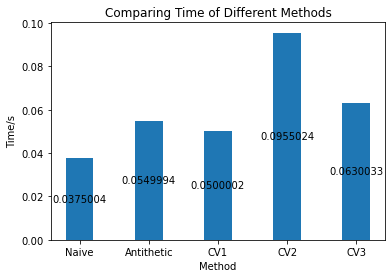

In [19]:
# Plot graph of time taken to run functions of different methods

_, _, Naive_time = SDE_asian_call_vol(110, K, T, r, sigma_0, Npaths)

_, _, Ant_time = SDE_asian_call_volant(110,K,T,r,sigma_0,Npaths)

_, _, cv1_time = SDE_control_variate_1(110, K, T, r, sigma_0, Npaths)

_, _, cv2_time = SDE_control_variate_2(110, K, T, r, sigma_0, Npaths)

_, _, cv3_time = SDE_control_variate_3(110, K, T, r, sigma_0, Npaths)


names = ['Naive', 'Antithetic', 'CV1', 'CV2', 'CV3']
time_results = [Naive_time, Ant_time, cv1_time, cv2_time, cv3_time]

fig, ax = plt.subplots()

p1 = ax.bar(names, time_results, width=0.4,)

ax.bar_label(p1, label_type='center')
ax.set_xticks(names)
ax.set_xlabel("Method")
ax.set_ylabel("Time/s")
ax.set_title("Comparing Time of Different Methods")
plt.show()

We see that the Naive method is the least computationally complex while the method using control variate 2 is the most computational complex, perhaps due to the fact that we call the Black-Scholes call function in the calculation of the expectation of control variate 2 in the function. We also notice that the method using control variate 3 is very slightly more computationally complex than the antithetic method, but this difference in time is so small that it may as well be ignored and we say that the antithetic method is as computationally complex as the method using control variate 3. Hence we can say that the method for control variate 3 is the most efficient for most spot prices except for ones which are significantly higher than the strike price where we then say that the antithetic method is the most efficient since we want to both minimise variance and the time taken to price the option.

# Discussion of results

The naive method for pricing an option is a simple approach in which the expected value of the option is estimated by calculating its payoffs across a large number of scenarios and then taking the average. The main benefit of the naive method is its simplicity. It is a straightforward approach that is easy to understand and implement which is why it is of such a low computational complexity. However, it is not very accurate as it has the highest variance out of all the methods.

The antithetic method is an approach in which two sets of scenarios are generated, one set with positive correlations between the underlying assets and another set with negative correlations. This reduces the impact of randomness on the results, hence reducing the variance of the Monte Carlo estimates and improving the accuracy of the option price. However, it is more computationally complex than the naive method but this is negligible as the time difference is not of significant size.

The method of control variates is a method in which the expected value of the option is estimated by using a control variate. This approach reduces the impact of randomness on the results and hence increases the accuracy of the option price. It is more computationally complex than the naive method and it may or may not be more computationally complex than the antithetic method based on the control variate used. The main disadvantage of the method of control variates is that it requires an accurate estimate of the expected value of the control variate. If the control variate's expected value is not accurately estimated, then the accuracy of the option's expected value will be reduced.

With all of this in mind, the choice of which option pricing method to use depends on the parameters of the option being priced and the desired level of accuracy. We see that for spot prices significantly higher than the strike price the antithetic method is slightly more accurate and less computationally complex than the method using control variate 3. For most other spot prices however, control variate 3 is significantly more accurate. Therefore, even with considering the additional cost of variance reduction computations, we argue that the method using control variate 3 is the most efficient for this problem as it is the best method to use for most initial values of spot price.

# Plot option price as a function of spot price

We plot option price as a function of spot price over the range $S_0 = 10$ to $S_0 = 180$ using the method that gives the smallest variance. Since the smallest variance depends on the size of $S_0$ we shall make two plots to investigate the two methods further.

In [20]:
#Set parameters

S = 110
K= 110
T=3
r=0.05
sigma_0=0.2
Npaths=1000

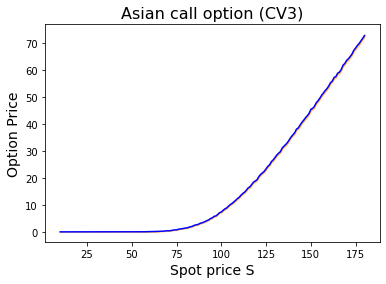

In [21]:
# create an array of spot prices S:
S_plot = np.arange(10,181,1)

# create arrays to store results for plotting
Npts = len(S_plot)
price_plot = np.zeros(Npts)
var_plot = np.zeros(Npts)

# price the option at each spot price
for k in range(Npts):
    price_plot[k], var_plot[k], _ = SDE_control_variate_3(S_plot[k],K,T,r,sigma_0,Npaths)
    
# plot the 95% confidence interval as a shaded region
SEM = np.sqrt(var_plot/Npaths)
plt.fill_between(S_plot, price_plot - 1.96*SEM, price_plot + 1.96*SEM, alpha=0.5, color="darkorange")

# plot the mean
plt.plot(S_plot, price_plot,'-b')

plt.xlabel("Spot price S", fontsize="14")
plt.ylabel("Option Price", fontsize="14")
plt.title("Asian call option (CV3)", fontsize="16")
plt.show()

The spot price is the current price of the underlying asset. Specifically, if the spot price increases, the option price will generally increase, and if the spot price decreases (unless it is already below 75), the option price will generally decrease as implied from the plot above. This is because options tend to gain value when the underlying asset price increases and lose value when the underlying asset price decreases.

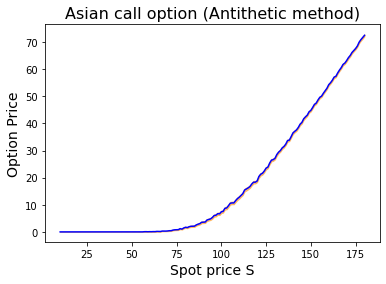

In [22]:
#price the option at each spot price
for k in range(Npts):
    price_plot[k], var_plot[k], _ = SDE_asian_call_volant(S_plot[k],K,T,r,sigma_0,Npaths)
    
# plot the 95% confidence interval as a shaded region
SEM = np.sqrt(var_plot/Npaths)
plt.fill_between(S_plot, price_plot - 1.96*SEM, price_plot + 1.96*SEM, alpha=0.5, color="darkorange")

# plot the mean
plt.plot(S_plot, price_plot,'-b')

plt.xlabel("Spot price S", fontsize="14")
plt.ylabel("Option Price", fontsize="14")
plt.title("Asian call option (Antithetic method)", fontsize="16")
plt.show()

We notice that the curve for the antithetic method is less smooth than that for the method using control variate 3 so we can argue that the method using control variate 3 is most accurate overall. This furthermore shows that control variate 3 is the most efficient for this problem.

We will now investigate the effect of different times to maturity on the option price of an Asian call option:

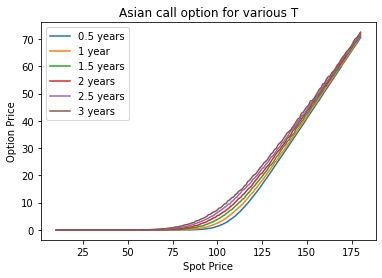

In [23]:
# create array of times and to store results for plotting
T_plot = np.arange(0.5,3.5,0.5)
price = np.zeros((len(S_plot), len(T_plot)))

# price the option at each spot price and time using a nested for loop
for i in range(len(T_plot)):
    for j in range(len(S_plot)):
        price[j][i], _, _ = SDE_control_variate_3(S_plot[j], K, T_plot[i], r, sigma_0, Npaths)

#plot the mean        
for i in range(len(T_plot)):
    plt.plot(S_plot,  price[:,i])
    
plt.xlabel("Spot Price")
plt.ylabel("Option Price")
plt.legend(["0.5 years", "1 year", "1.5 years", "2 years", "2.5 years", "3 years"])
plt.title("Asian call option for various T")
plt.show()

We also see that as the time to maturity increases the option price increases for an Asian option at a range of spot prices from 80 to 130 showcasing a lower gradient for high T but outside of that range the option price is relatively equal. Hence, as the time to maturity decreases, the option price will become more sensitive to changes in the underlying spot price, and vice versa. This is because an option has a limited amount of time to realize its payoff, and as the time to maturity approaches, the option price will become increasingly sensitive to changes in the underlying spot price.

Let us compare Asian option prices with their European counterparts: 

In [24]:
def MC_euro_call_ant(S, K, T, r, sigma, N):
    
    # Compute European call option price using antithetic variance reduction
    
    # Set parameters
    S0 = S
    
    X = rng.normal(0,1,N)
    STp = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*X)
    STm = S0*np.exp((r-0.5*sigma**2)*T-sigma*np.sqrt(T)*X)
    fSTp = np.exp(-r*T)*np.maximum(STp-K,0)
    fSTm = np.exp(-r*T)*np.maximum(STm-K,0)
    Z = (fSTp+fSTm)/2.
    
    price = np.mean(Z)
    variance = np.var(Z)
    return price, variance

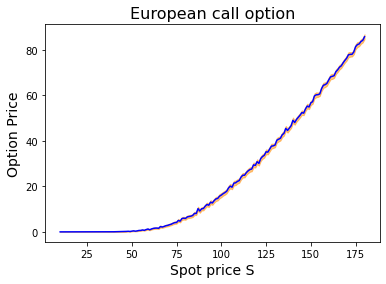

In [25]:
# price the option at each spot price
for k in range(Npts):
    price_plot[k], var_plot[k] = MC_euro_call_ant(S_plot[k],K,T,r,sigma_0,Npaths)
    
# plot the 95% confidence interval as a shaded region
SEM = np.sqrt(var_plot/Npaths)
plt.fill_between(S_plot, price_plot - 1.96*SEM, price_plot + 1.96*SEM, alpha=0.5, color="darkorange")

# plot the mean
plt.plot(S_plot, price_plot,'-b')

plt.xlabel("Spot price S", fontsize="14")
plt.ylabel("Option Price", fontsize="14")
plt.title("European call option", fontsize="16")
plt.show()

Comparing the graphs of the Asian call option and the European call option we see that the option price of a European call option starts to increase at a lower spot price of around 50 than that of the Asian call option which seems to be around 75. We also see that the option price of a European call option reaches 80 at a spot price of 180 which is higher than that of an Asian call option. 

# Computation of the delta for the Asian option

We choose the pathwise method of computing the delta for an Asian option. This is a numerical approach that uses Monte Carlo simulation to estimate the change in the price of the option as the underlying asset price changes. In this approach, the price of the option is simulated for different underlying asset prices, and the delta is estimated as the difference in the option price across these prices. This approach is relatively simple to implement and can be applied to any type of option. However, it is computationally intensive and may not be accurate for options with a complex underlying asset price distribution.

A pathwise delta is a numerical measure that shows how much the price of an option will change in response to a change in the underlying spot price. If the delta is positive, then the option price will increase as the spot price increases, and if the delta is negative, then the option price will decrease as the spot price increases. The delta is typically expressed as a percentage, with a positive delta indicating that the option price will increase by that percentage if the spot price increases by 1%.

In [26]:
# Simulate GBM and compute the delta using the pathwise method
def SDE_asian_call_delta(S0, K, T, r, sigma_0, Npaths):

    t, S, Z = SDE_control_timestepper(S0, T, r, sigma_0, Npaths)
    
    D = np.exp(-r*T)*(S[-1,:]/S[0,:])*np.heaviside(np.mean(S, axis=0) - K, 0)
    
    delta = np.mean(D)
    variance = np.var(D)
    return delta, variance

In [27]:
#Set parameters

S = 110
K= 110
T=3
r=0.05
sigma_0=0.2
Npaths=1000

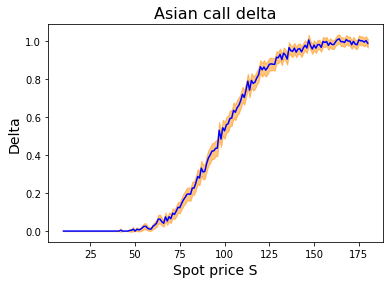

In [28]:
# create an array of spot prices S:
S_plot = np.arange(10,181,1)

# create arrays to store results for plotting
Npts = len(S_plot)
delta_plot = np.zeros(Npts)
var_plot = np.zeros(Npts)

# price the option at each spot price
for k in range(Npts):
    delta_plot[k], var_plot[k] = SDE_asian_call_delta(S_plot[k],K,T,r,sigma_0,Npaths)
    
# plot the 95% confidence interval as a shaded region
SEM = np.sqrt(var_plot/Npaths)
plt.fill_between(S_plot, delta_plot - 1.96*SEM, delta_plot + 1.96*SEM, alpha=0.5, color="darkorange")

# plot the mean
plt.plot(S_plot, delta_plot,'-b')

plt.xlabel("Spot price S", fontsize="14")
plt.ylabel("Delta", fontsize="14")
plt.title("Asian call delta", fontsize="16")
plt.show()

Delta is a measure of how the price of a derivative changes in response to moves in the price of the underlying asset and so we can see that graphically it is similar to the gradient of the option price as a function of the spot price.

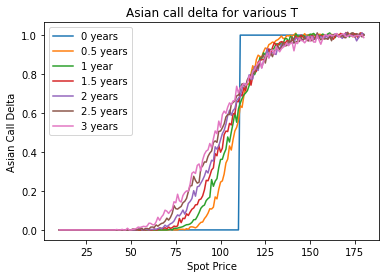

In [29]:
# create array of times and to store results for plotting
T_plot = np.arange(0,3.5,0.5)
delta = np.zeros((len(S_plot), len(T_plot)))

# price the option at each spot price and time using a nested for loop
for i in range(len(T_plot)):
    for j in range(len(S_plot)):
        delta[j][i], _ = SDE_asian_call_delta(S_plot[j], K, T_plot[i], r, sigma_0, Npaths)
        
#plot the mean
for i in range(len(T_plot)):
    plt.plot(S_plot,  delta[:,i])
    
plt.xlabel("Spot Price")
plt.ylabel("Asian Call Delta")
plt.legend(["0 years", "0.5 years", "1 year", "1.5 years", "2 years", "2.5 years", "3 years"])
plt.title("Asian call delta for various T")
plt.show()

Here we yet again see a steeper gradient at lower times to maturity within the range of 80 to 130 for the spot price. This is again because an option has a limited amount of time to realize its payoff, and as the time to maturity approaches, the delta will become increasingly sensitive to changes in the underlying spot price.

We now want to compare the Asian call delta to the European call delta and analyze the similarities and/or dissimilarities

In [30]:
def MC_euro_call_delta_pathwise(S, K, T, r, sigma, N):

    # Set parameters
    S0 = S
    
    X = rng.normal(0,1,N)
    ST = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*X)
    Z = np.exp(-r*T)*(ST/S0)*np.heaviside(ST-K,0.5)
    
    delta = np.mean(Z)
    variance = np.var(Z)
    return delta, variance

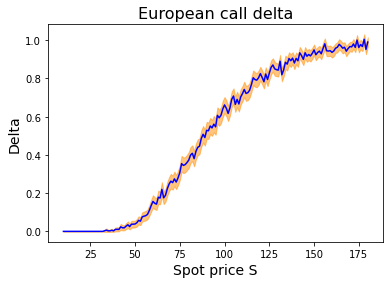

In [31]:
# create an array of spot prices S:
S_plot = np.arange(10,181,1)

# create arrays to store results for plotting
Npts = len(S_plot)
delta_plot = np.zeros(Npts)
var_plot = np.zeros(Npts)

# price the option at each spot price
for k in range(Npts):
    delta_plot[k], var_plot[k] = MC_euro_call_delta_pathwise(S_plot[k],K,T,r,sigma_0,Npaths)
    
# plot the 95% confidence interval as a shaded region
SEM = np.sqrt(var_plot/Npaths)
plt.fill_between(S_plot, delta_plot - 1.96*SEM, delta_plot + 1.96*SEM, alpha=0.5, color="darkorange")

# plot the mean
plt.plot(S_plot, delta_plot,'-b')

plt.xlabel("Spot price S", fontsize="14")
plt.ylabel("Delta", fontsize="14")
plt.title("European call delta", fontsize="16")
plt.show()

Foremost, we notice that the function of the Asian call delta against spot price has a steeper gradient than that of the European call delta at spot prices from 75 to 130 at maturity. This means that the delta of an Asian call option is generally more sensitive to changes in the underlying spot price than the delta of a European call option.

# Conclusions

In this notebook we have investigated the effects of various methods on the pricing of a Fixed Strike Asian Call Option with Discrete Arithmetic Average. We see that overall, the method using control variate 3 for the most part is the most efficient for pricing an Asian option for most parameters. The computational complexity of this method is negligible as the difference in time taken between this method and the naive method which was the shortest time taken was 0.02 seconds.

We also saw the effect the time to maturity has on the option price and delta of the Asian call option as the lower the time to maturity the higher the gradient for both option price and delta of an Asian call option as a function of spot price. 

We also noted that by a comparison of prices and deltas of an Asian call option and its European counterpart that an Asian call option is generally more sensitive to changes in the spot price.